# How to load processed data

In [1]:
# HIDE CODE


import os
import sys
import h5py
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# warnings, tqdm, & style
%matplotlib inline

## Load an expt (Nardin)

In [2]:
base_dir = '/home/hadi/Documents/MTMST'
load_dir = pjoin(base_dir, 'MTLFP-MST', 'xtracted_python')
file = pjoin(load_dir, 'NARDIN_tres25.h5')
file = h5py.File(file, 'r')

In [3]:
name = 'slu020'
group = file[name]
list(group)

['badspks',
 'cellindex',
 'field',
 'fixlost',
 'hyperflow',
 'latency',
 'lfp',
 'nx',
 'ny',
 'partition',
 'rf_loc',
 'spatres',
 'spks',
 'stim1',
 'stim2']

In [4]:
partition = np.array(group['partition'], dtype=int)
spks = np.array(group['spks'], dtype=float)
nans = np.isnan(spks)
good_channels = nans.sum(0) == 0
good_spks = ~np.array(group['badspks'], dtype=bool)

In [5]:
good_spks.sum() / len(good_spks)

0.8134953703703703

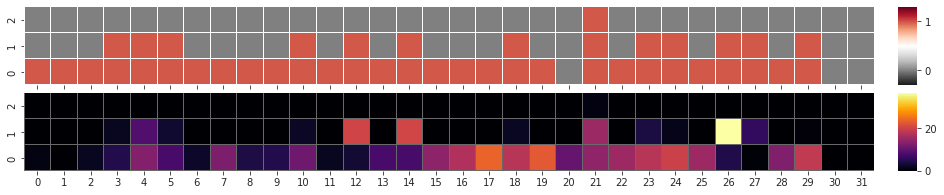

In [13]:
fig, axes = create_figure(2, 1, (13, 2.6), sharex='all', constrained_layout=True)
sns.heatmap(
    good_channels.T,
    cmap='RdGy_r',
    linewidths=0.01,
    vmin=-0.3,
    vmax=1.3, 
    linecolor='w',
    ax=axes[0],
)
sns.heatmap(
    np.nansum(spks, 0).T / len(spks) / 25e-3,
    cmap='inferno',
    linewidths=0.01,
    linecolor='dimgrey',
    ax=axes[1],
)
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

## HyperFlow

In [16]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=2,
    radius=7,
)

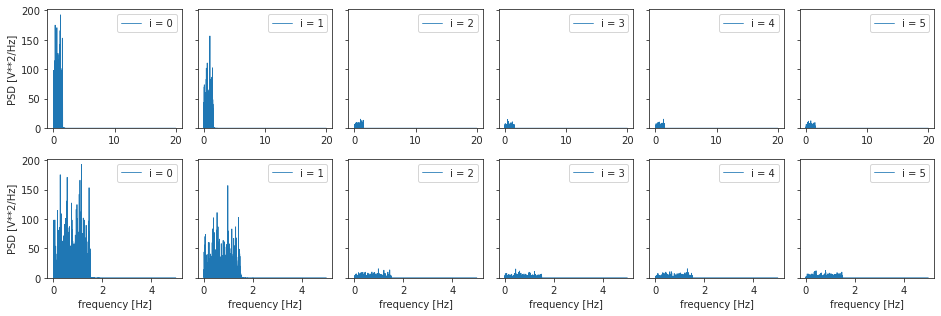

In [17]:
_ = hf.show_psd('opticflow', False, cutoff=5)

In [18]:
stim = hf.compute_hyperflow()
stim.shape

(43200, 16, 16, 2)

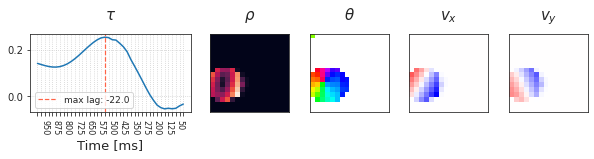

In [19]:
t = 700
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

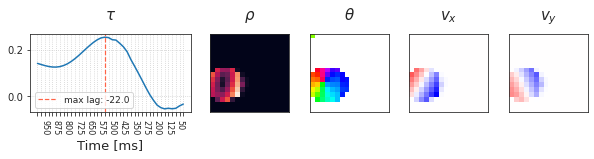

In [20]:
t = 700 + 14400
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

## STA

In [24]:
from analysis.sta import compute_sta

lags = 24

### HF generated (1st segment)

In [25]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

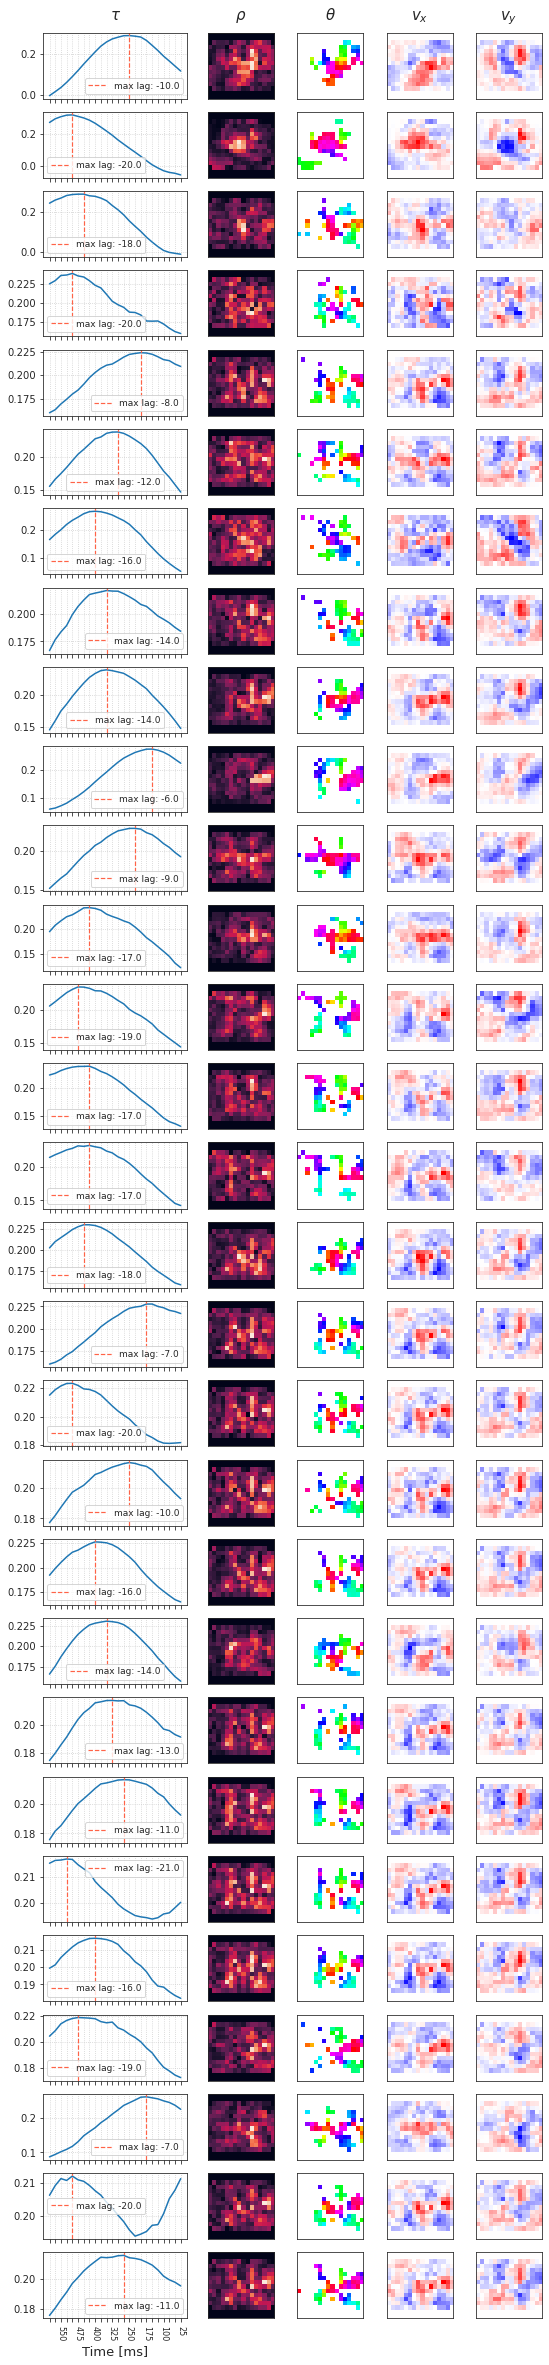

In [27]:
sta = VelField(sta[good_channels[..., 0]], name=name)
_ = sta.show()

### Original stim (1st segment)

In [30]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=np.array(group['stim1'], dtype=float)[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 15, 15, 2)

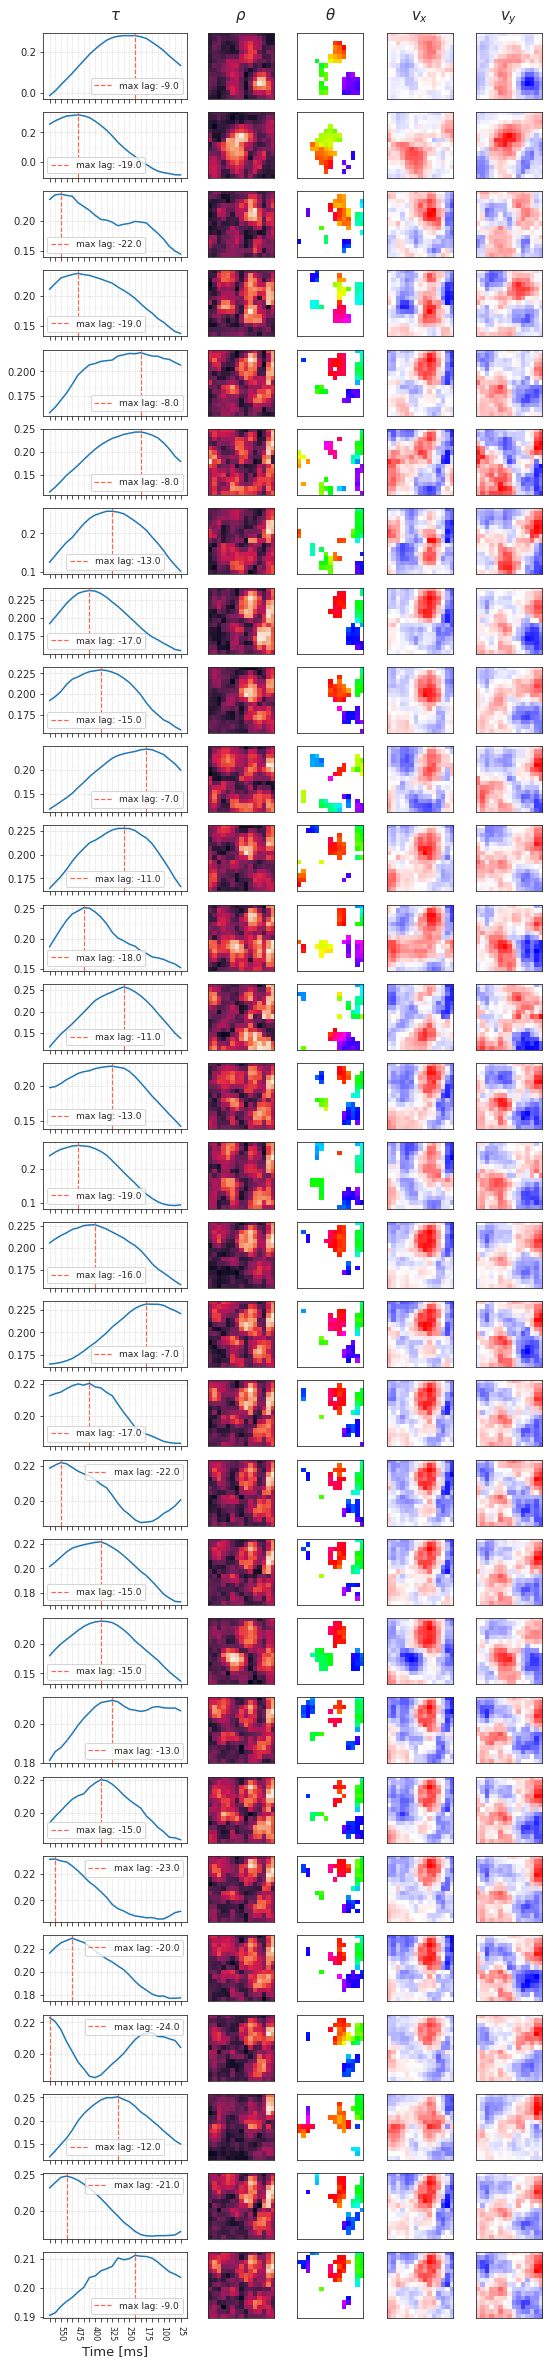

In [31]:
sta = VelField(sta[good_channels[..., 0]], name=name)
_ = sta.show()

## STA (with fine HF gen stim)

In [32]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=64,
    sres=1,
    radius=7,
)
stim = hf.compute_hyperflow()

In [ ]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

In [ ]:
sta = VelField(sta[good_channels[..., 0]], name=name)
_ = sta.show()

In [ ]:
stim.shape

In [4]:
path = '/home/hadi/Documents/MTMST/Nardin/MTproject_data/xtracted'
expt = 'tres25_slu020'
load_file = pjoin(path, f'{expt}.mat')

In [5]:
from scipy import io as sio
mat = sio.loadmat(load_file)
len(mat)

37

In [55]:
segments = mat['partition'].ravel().astype(int)
spks = mat['spks'].astype(float)
nans = np.isnan(spks)
good_channels = nans.sum(0) == 0
good_spks = ~mat['badspks'].astype(bool)

In [6]:
good_spks.sum() / len(good_spks)

0.8134953703703703

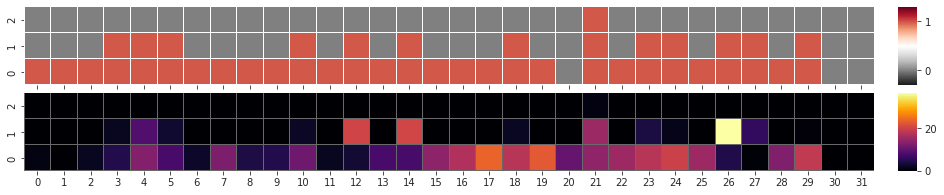

In [8]:
fig, axes = create_figure(2, 1, (13, 2.6), sharex='all', constrained_layout=True)
sns.heatmap(
    good_channels.T,
    cmap='RdGy_r',
    linewidths=0.01,
    vmin=-0.3,
    vmax=1.3, 
    linecolor='w',
    ax=axes[0],
)
sns.heatmap(
    np.nansum(spks, 0).T / len(spks) / 25e-3,
    cmap='inferno',
    linewidths=0.01,
    linecolor='dimgrey',
    ax=axes[1],
)
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

In [10]:
hf = HyperFlow(
    opticflow=mat['opticflows'].astype(float),
    center=np.concatenate([
        mat['centerx'],
        mat['centery']
    ], axis=1).astype(float),
    size=32,
    sres=2,
    radius=7,
)

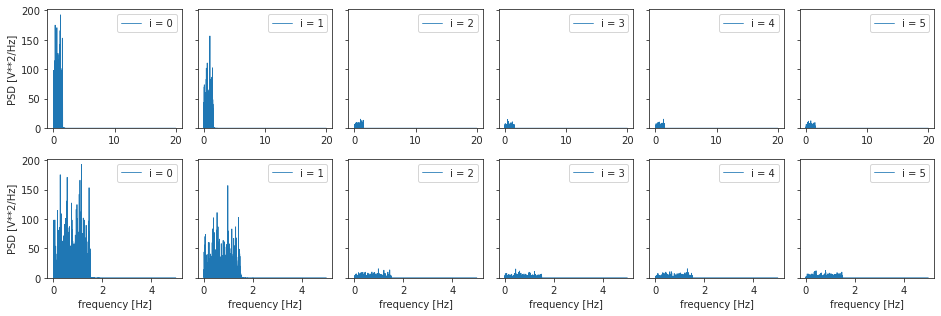

(43200, 16, 16, 2)

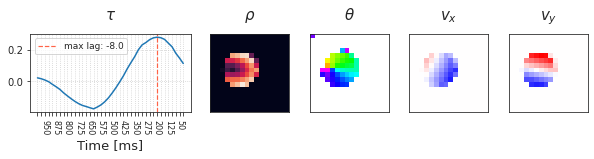

In [13]:
vf = VelField(stim[100:140])
_ = vf.show(fig_x=10)

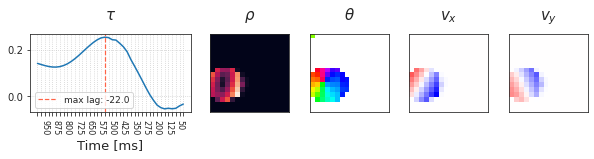

In [14]:
t = 700
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

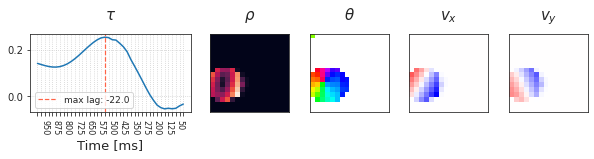

In [15]:
t = 700 + 14400
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

In [16]:
x = np.concatenate([
    mat['centerx'],
    mat['centery'],
    mat['opticflows'],
], axis=1).astype(float)
x.shape

(43200, 8)

In [17]:
mat['partition'].astype(int).ravel()

array([    0, 14400, 28800, 43200])

In [18]:
t = 1000
x[t], x[t + 14400], x[t + 28800]

(array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]),
 array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]),
 array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]))

In [25]:
lags = 24

In [50]:
stim.shape

(43200, 16, 16, 2)

array([    0, 14400, 28800, 43200], dtype=uint16)

In [26]:
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks)[0],
    stim=stim,
    spks=spks[..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

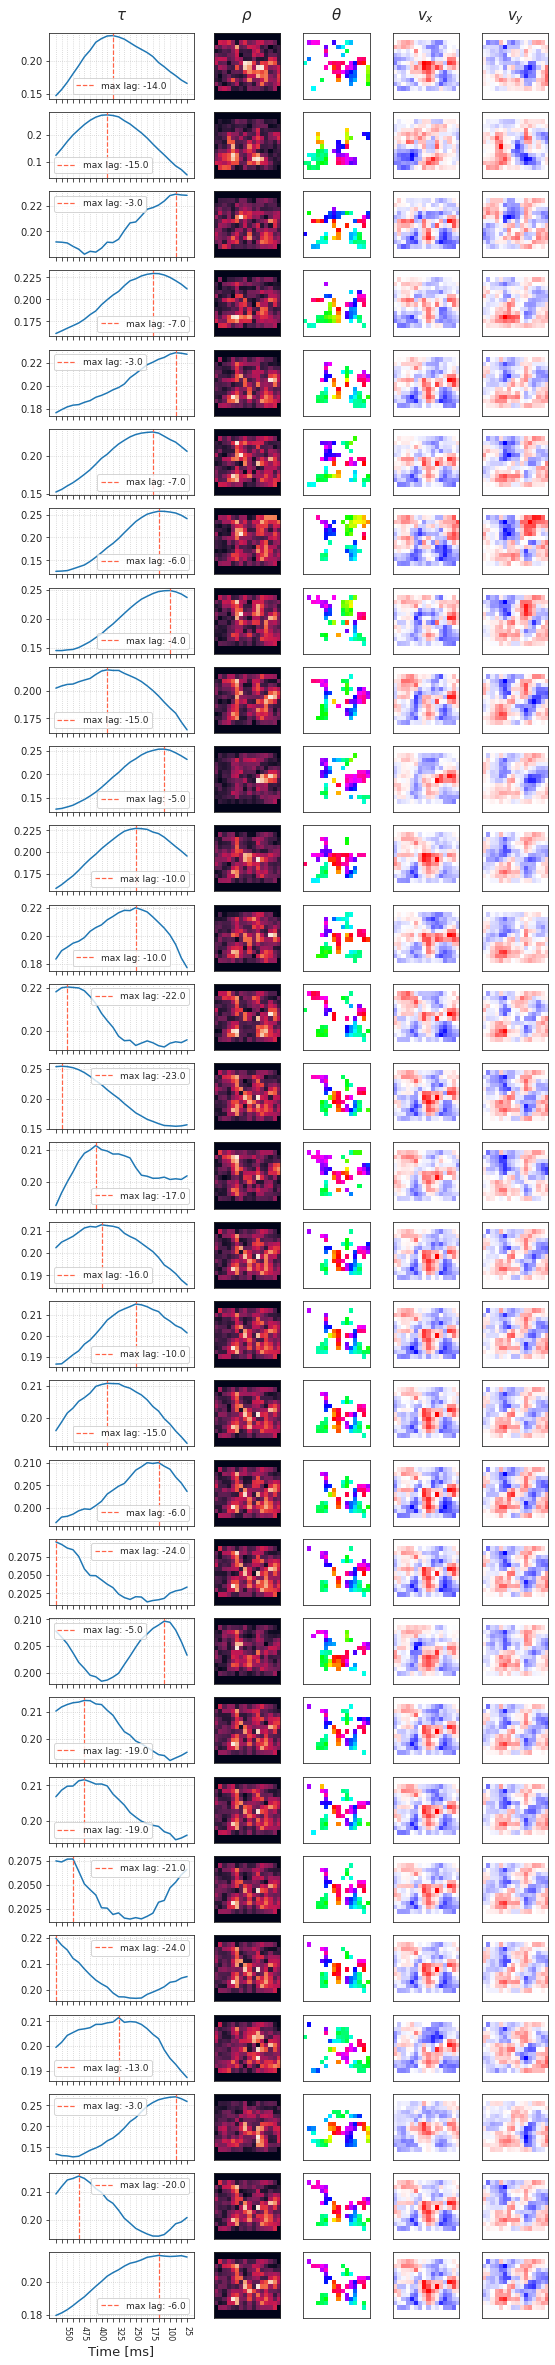

In [49]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [60]:
seg = range(segments[0], segments[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

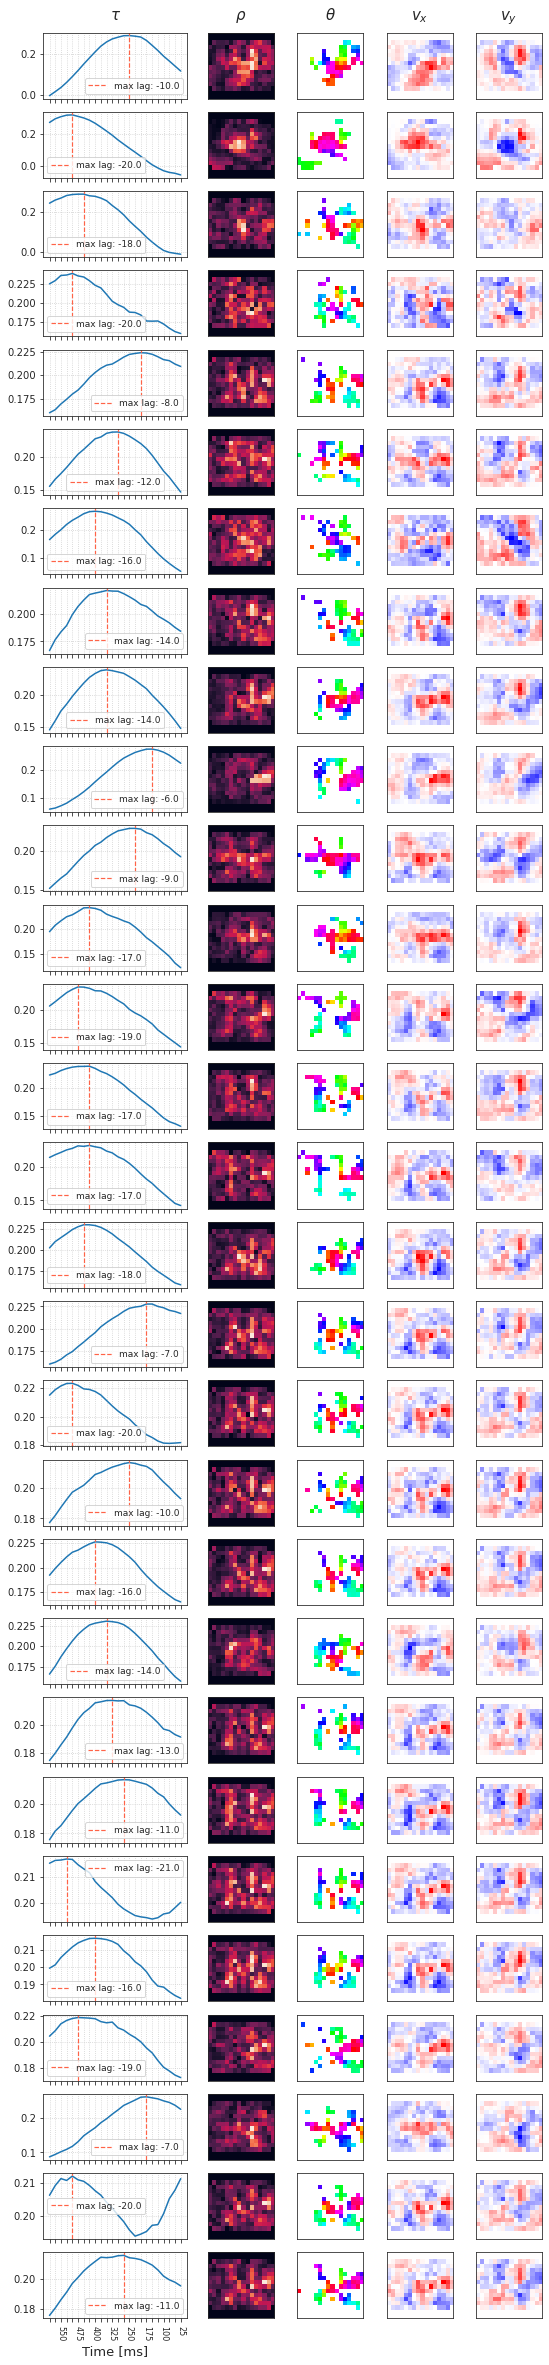

In [61]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [62]:
seg = range(segments[1], segments[2])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

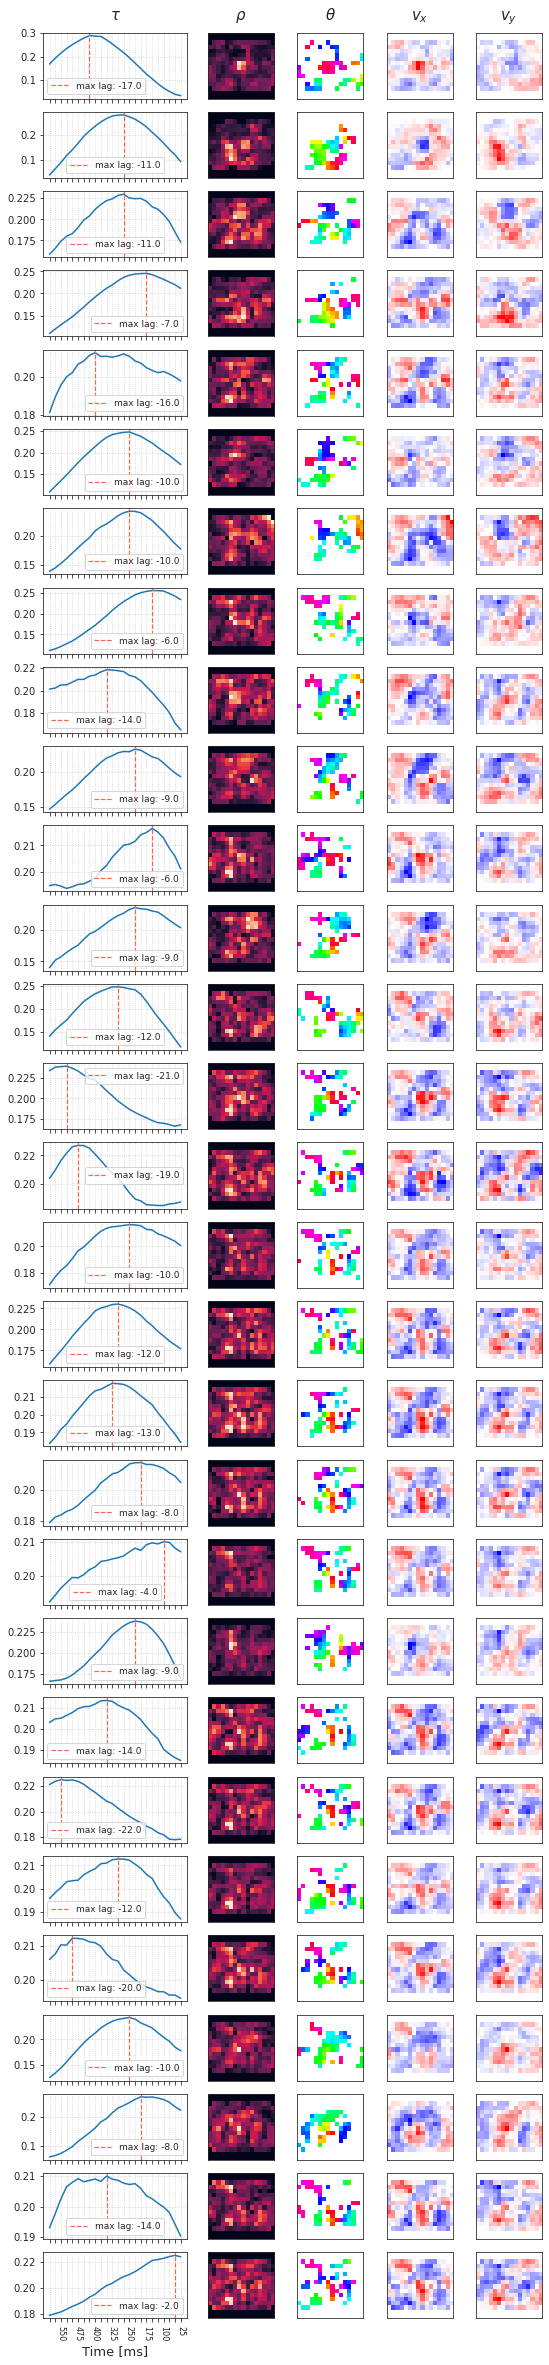

In [63]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [64]:
seg = range(segments[2], segments[3])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

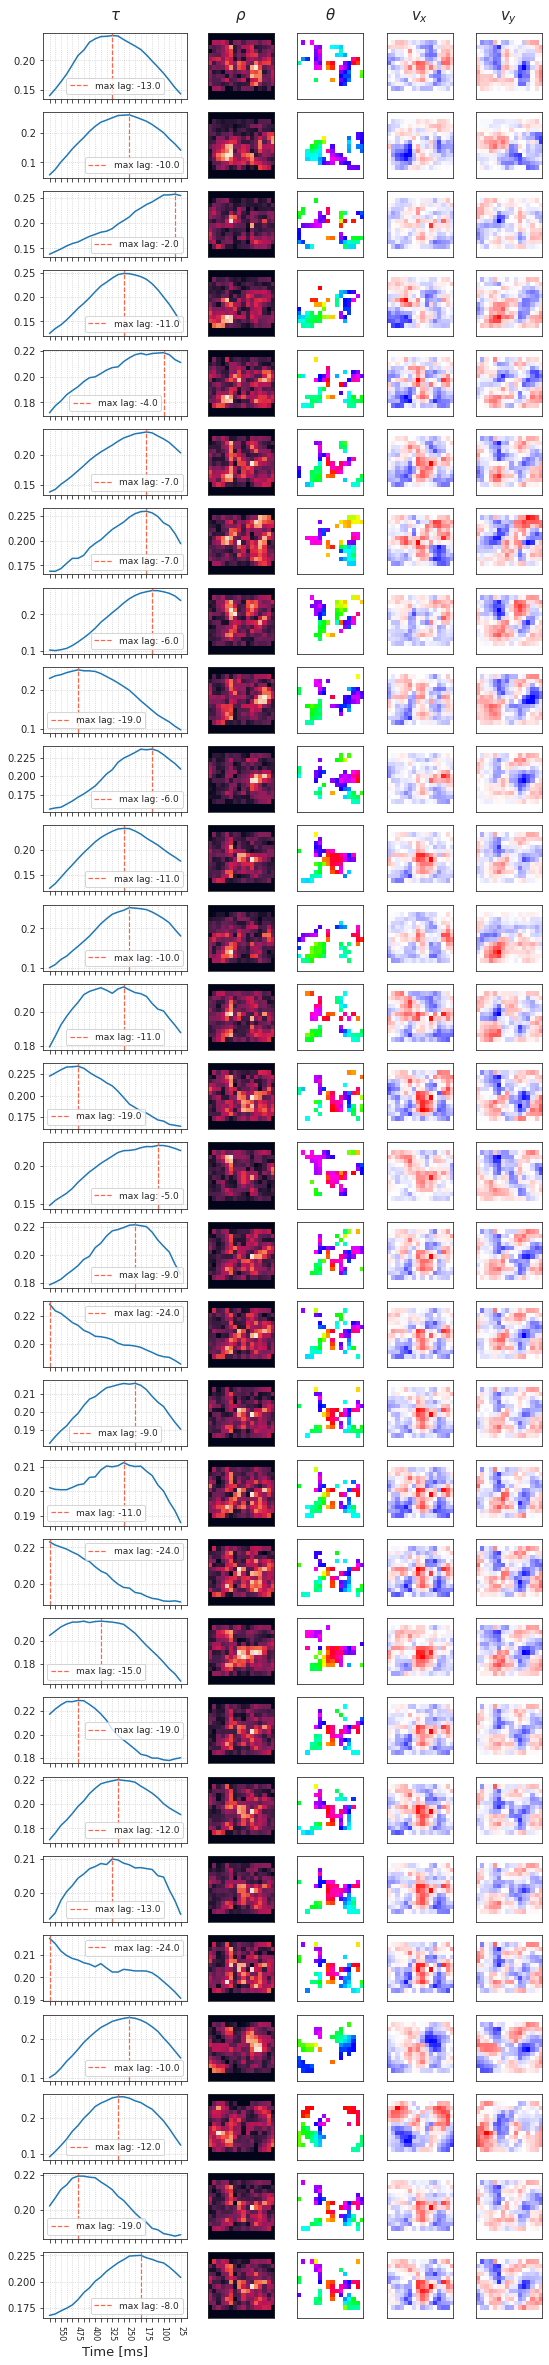

In [65]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [66]:
mat['stim1'].astype(float).shape

(43200, 450)

In [ ]:
seg = range(segments[0], segments[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()